In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter

In [7]:
# Load the two topography files, one in WGS84, other in CRT
df_CRT = pd.read_table('Survey_24_09_25_CRTM05.txt', sep='\s+', header=None, names=['id', 'N', 'E', 'z', 'label'], skiprows=[0,1,94])
df_WGS = pd.read_table('Survey_24_09_25_WGS84.txt', sep='\s+', header=None, names=['id', 'N', 'E', 'z', 'label'], skiprows=[0,1,94])

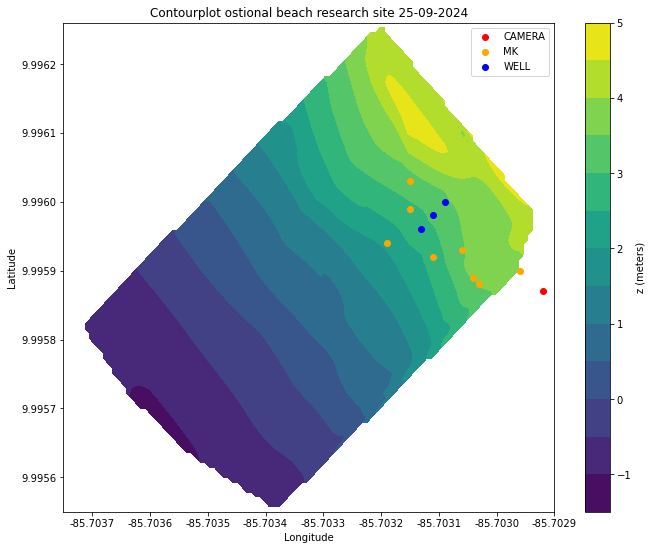

In [8]:
# Filter out 'CAMERA' and 'WELL' labels
df_contour = df_WGS[~df_WGS['label'].isin(['CAMERA', 'WELL'])]

# Extract coordinates and values
x_contour, y_contour, z_contour = df_contour['E'].values, df_contour['N'].values, df_contour['z'].values

# Create grid for interpolation
xi, yi = np.linspace(min(x_contour), max(x_contour), 100), np.linspace(min(y_contour), max(y_contour), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values on the grid
zi = griddata((x_contour, y_contour), z_contour, (xi, yi), method='cubic')

# Create contour plot
plt.figure(figsize=(11, 9))
contour = plt.contourf(xi, yi, zi, levels=14, cmap='viridis')

# Plot scatter points for different labels
labels_colors = [('CAMERA', 'red'), ('MK', 'orange'), ('WELL', 'blue')]
for label, color in labels_colors:
    df_filtered = df_WGS[df_WGS['label'] == label]
    plt.scatter(df_filtered['E'], df_filtered['N'], c=color, label=label)

# Add color bar and labels
plt.colorbar(contour, label='z (meters)')
plt.legend()

# Set axis labels, title, and limits
plt.xlim(-85.70375, -85.7029)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Contourplot ostional beach research site 25-09-2024')

# Format x-axis with 4 decimal places
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.4f}'))

plt.show()



In [9]:
def lat_lon_to_meters(lat, lon):
    # Radius of the Earth in meters
    R = 6371000  
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Calculate the x and y coordinates in meters
    x = R * lon_rad * np.cos(lat_rad)
    y = R * lat_rad
    
    return x, y

In [10]:
from pyproj import Proj, transform

def lat_lon_to_utm(lat, lon):
    # Create a Proj object for the UTM zone (determined by longitude)
    # Determine UTM zone based on longitude
    utm_zone = int((lon + 180) / 6) + 1
    proj_utm = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Transform latitude and longitude to UTM coordinates
    x, y = proj_utm(lon, lat)
    return x, y

In [11]:
# Assuming df_WGS is already defined
# Filter the DataFrame for rows where 'label' is 'MK' and select specific columns
df_MK_WGS = (df_WGS[df_WGS['label'] == 'MK']
             .assign(id=lambda df: df['id'].astype(str).str.replace('^40', '', regex=True))
             .rename(columns={'N': 'latitude', 'E': 'longitude', 'z': 'z'})
             .sort_values(by='id')
             .reset_index(drop=True)
             [['id', 'latitude', 'longitude', 'z']])

# Save to CSV and display the DataFrame
df_MK_WGS.to_csv('df_MK_WGS.txt', index=False, header=False, sep=',')
display(df_MK_WGS)

,id,latitude,longitude,z
0,1,9.99594,-85.70319,2.194
1,2,9.99599,-85.70315,2.961
2,3,9.99603,-85.70315,3.261
3,4,9.99592,-85.70311,2.781
4,5,9.99593,-85.70306,3.435
5,6,9.99589,-85.70304,3.541
6,7,9.99588,-85.70303,3.530
7,8,9.99590,-85.70296,3.912


In [12]:
# Filter the DataFrame for rows where 'label' is 'MK' and select specific columns
df_wells_WGS = (df_WGS[df_WGS['label'] == 'WELL']
             .assign(id=lambda df: df['id'].astype(str).str.replace('^40', '', regex=True))
             .rename(columns={'N': 'latitude', 'E': 'longitude', 'z': 'z'})
             .sort_values(by='id')
             .reset_index(drop=True)
             [['id', 'latitude', 'longitude', 'z']])

# Save to CSV and display the DataFrame
df_wells_WGS.to_csv('df_wells_WGS.txt', index=False, header=False, sep=',')
display(df_wells_WGS)

,id,latitude,longitude,z
0,112,9.99600,-85.70309,3.600
1,117,9.99598,-85.70311,3.301
2,123,9.99596,-85.70313,2.981


In [13]:
# Filter, rename columns, and process 'id' in a single step
df_MK_UTM = (df_WGS[df_WGS['label'] == 'MK']
             .assign(id=lambda df: df['id'].astype(str).str.replace('^40', '', regex=True))
             .rename(columns={'N': 'latitude', 'E': 'longitude', 'z': 'z'})
             .reset_index(drop=True)
            )

# Convert latitude and longitude to UTM coordinates row-wise
df_MK_UTM[['x', 'y']] = df_MK_UTM.apply(lambda row: lat_lon_to_utm(row['latitude'], row['longitude']), axis=1, result_type='expand')

# Sort the DataFrame by the 'id' column
df_MK_UTM = df_MK_UTM.sort_values(by='id')

# Optional: Reorder columns if needed
df_MK_UTM = df_MK_UTM[['id', 'x', 'y', 'z']]

# Save to CSV and display the DataFrame
df_MK_UTM.to_csv('df_MK_UTM.txt', index=False, header=False, sep=',')
display(df_MK_UTM)


,id,x,y,z
6,1,642137.796820,1.105243e+06,2.194
7,2,642142.160029,1.105248e+06,2.961
0,3,642142.142646,1.105253e+06,3.261
1,4,642146.575386,1.105241e+06,2.781
2,5,642152.052212,1.105242e+06,3.435
3,6,642154.262065,1.105237e+06,3.541
4,7,642155.362646,1.105236e+06,3.530
5,8,642163.027595,1.105239e+06,3.912


In [14]:
# Filter, rename columns, and process 'id' in a single step
df_CAM_UTM = (df_WGS[df_WGS['label'] == 'CAMERA']
             .assign(id=lambda df: df['id'].astype(str).str.replace('^40', '', regex=True))
             .rename(columns={'N': 'latitude', 'E': 'longitude', 'z': 'z'})
             .reset_index(drop=True)
            )

# Convert latitude and longitude to UTM coordinates row-wise
df_CAM_UTM[['x', 'y']] = df_CAM_UTM.apply(lambda row: lat_lon_to_utm(row['latitude'], row['longitude']), axis=1, result_type='expand')

# Sort the DataFrame by the 'id' column
df_CAM_UTM = df_CAM_UTM.sort_values(by='id')

# Optional: Reorder columns if needed
df_CAM_UTM = df_CAM_UTM[['id', 'x', 'y', 'z']]

# Save to CSV and display the DataFrame
df_CAM_UTM.to_csv('df_CAM_UTM.txt', index=False, header=False, sep=',')

display(df_CAM_UTM)



,id,x,y,z
0,250,642167.425573,1.105235e+06,5.309


In [15]:
# Filter, rename columns, process 'id', and convert to UTM in one step
df_wells_UTM = (df_WGS[df_WGS['label'] == 'WELL']
                .assign(id=lambda df: df['id'].astype(str).str.replace('^40', '', regex=True),
                        latitude=df_WGS['N'], longitude=df_WGS['E'])
                .reset_index(drop=True))

# Convert latitude and longitude to UTM and keep 'id' and 'z'
df_wells_UTM[['x', 'y']] = df_wells_UTM.apply(lambda row: lat_lon_to_utm(row['latitude'], row['longitude']), axis=1, result_type='expand')

# Sort by 'id' and reorder columns
df_wells = df_wells_UTM[['id', 'x', 'y', 'z']].sort_values(by='id').reset_index(drop=True)

# Save to CSV and display the DataFrame
df_wells.to_csv('df_wells_UTM.txt', index=False, header=False, sep=',')

display(df_wells)


,id,x,y,z
0,112,642148.733088,1.105250e+06,3.600
1,117,642146.549311,1.105247e+06,3.301
2,123,642144.365534,1.105245e+06,2.981


In [16]:
# Get the coordinates of the first and second row
x1, y1 = df_wells.iloc[0][['x', 'y']]
x2, y2 = df_wells.iloc[2][['x', 'y']]

# Calculate the angle in radians
angle_radians = np.arctan2(y2 - y1, x2 - x1)

# Convert the angle to degrees
angle_degrees = np.degrees(angle_radians)

# Print the result
print(f"Angle between the first and second point: {-angle_degrees:.2f} degrees")


Angle between the first and second point: 134.52 degrees
